# **Sistema de recomendación basado en FBC para razas de perros**

## **Introducción**

Este cuarderno describe el proceso de preparación de los datos para la implementación de un sistema de recomendación mediante la técnica de filtrado basado en contenido (FBC) para razas de perros. Se detallan las técnicas empleadas durante la limpieza y transformación del conjunto de datos, así como la implementación de dos aproximaciones por el momento: uno basado en la similitud de coseno y otro en el procesamiento de lenguaje natural (NLP) con embbedings.

## **Metodología**

### **1. Preparación y limpieza de datos**

El conjunto de datos proviene del archivo akc-data-latest.csv, el cual incluye información detallada sobre 277 razas de perros, entre estos datos, se incluye:
- Descripción de la raza
- Temperamento
- Tamaño, peso y esperanza de vida
- Nivel de energía y facilidad de entrenamiento

#### **1.1. Identificación y manejo de valores nulos**

Se realizo un análisis con la librería de Pandas para detectar valores faltantes en cada columna y se realizaron las siguientes operaciones:
- Para valores nulos en columnas importantes como description o temperament, se consideró eliminar la fila completa del registro
- Para las columnas numéricas, se reemplazaron los valores nulos con la mediana de cada columna
- Para las columnas categóricas, los valores nulos se reemplazan con el valor más frecuente en la columna (moda).

> Para evitar errores en la transformación de los datos, las columnas numéricas se convirtieron en datos de tipo float

In [17]:
import pandas as pd

# Creamos el Dataframe de los datos
data_path = '../DogRecSys/data/akc-data-latest.csv'
df = pd.read_csv(data_path, encoding='utf-8')

# Creamos una copia del dataframe original para limpieza
df_clean = df.copy()

# Mostramos los valores nulos antes de la limpieza
print('Valores nulos antes de la limpieza:')
print(df_clean.isnull().sum())

# Hacemos la conversión de las columnas numéricas a tipo float, usando pd.to_numeric
numeric_cols = ['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight', 'min_expectancy', 'max_expectancy',
                'grooming_frequency_value', 'shedding_value', 'energy_level_value', 'trainability_value']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Eliminamos filas donde 'description', 'temperament' o 'group' sean nulos
initial_rows = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['description', 'temperament', 'group'])


print('Procedimiento realizado:')
# Para columnas numéricas, sustituimos con la mediana si tienen nulos
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        median = df_clean[col].median()
        df_clean[col].fillna(median, inplace=True)
        print('Valores nulos de col. ' + col + ' reemplazados por su mediana: ' + str(median))

# Para columnas categóricas con pocos nulos, rellenamos con el valor de moda
categorical_cols = ['grooming_frequency_category', 'shedding_category', 'energy_level_category', 'trainability_category', 'demeanor_category']
for col in categorical_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        mode = df_clean[col].mode()[0]
        df_clean[col].fillna(mode, inplace=True)
        print('Valores nulos de col. ' + col + ' reemplazados por su moda: : ' + str(mode))

# Mostramos el shape del dataframe después de la limpieza
final_rows = df_clean.shape[0]

# Mostramos las filas removidas y las dimensiones finales del dataframe
print('\
Filas removidas: ' + str(initial_rows - final_rows) + '\n')
print('Dimensiones finales del dataframe: ' + str(df_clean.shape))

Valores nulos antes de la limpieza:
breed                           0
description                     0
temperament                     1
popularity                     79
min_height                      0
max_height                      0
min_weight                      2
max_weight                      2
min_expectancy                  3
max_expectancy                  3
group                           0
grooming_frequency_value        7
grooming_frequency_category     7
shedding_value                 20
shedding_category              20
energy_level_value              6
energy_level_category           6
trainability_value             24
trainability_category          24
demeanor_value                 25
demeanor_category              25
dtype: int64
Procedimiento realizado:
Valores nulos de col. popularity reemplazados por su mediana: 96.0
Valores nulos de col. min_weight reemplazados por su mediana: 15.875732950000002
Valores nulos de col. max_weight reemplazados por su mediana: 24

/var/folders/0p/_tw7vhrx7r9c70s077md2wkw0000gn/T/ipykernel_11695/85719617.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median, inplace=True)
/var/folders/0p/_tw7vhrx7r9c70s077md2wkw0000gn/T/ipykernel_11695/85719617.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

### **2. Transformación de datos**

Para esta fase se consideraron los siguientes procedimientos:

- **Procesamiento de texto:** Las columnas como description y temperament contienen bastante información descriptiva que puede ser aprovechada mediante el procesamiento de lenguaje natural (NLP). Esto se puede vectorizar (por ejemplo, usando TF-IDF o embeddings) para capturar las características textuales.
- **Normalización/estandarización:** Las variables numéricas (como popularidad, alturas, pesos, etc.) podrían necesitar escalado para que su rango no influya de manera desproporcionada en la similitud.
- **Ingeniería de características:** Se podría crear nuevas variables o combinar atributos (por ejemplo, diferencias de alturas o pesos) que ayuden a distinguir mejor las razas.

#### **2.1. Procesamiento de texto**

TF-IDF hace referencia a Frecuencia de Término y Frecuencia de Documento Inversa o Term Frequency-Inverse Document Frequency, por sus siglas en inglés. Es una estadística que refleja la importancia de una palabra en un texto dentro de una colección de textos. Es usado ampliamente en la recuperación de información y minería de textos.

Funciona de la siguiente manera:
- **Term Frequency (TF)**: Mide qué tan seguido un término aparece dentro de un texto. Es calculado como el número de ocurrencias de un término dividido entre el total de términos en un texto.
- **Inverse Document Frequency (IDF)**: Mide la rareza de un término entre todo el conjunto de textos en la colección. Es calculado como el logaritmo del número total de textos dividido entre el número de textos que incluyen el termino. 
- **TF-IDF**: Es el producto de TF  y IDF, dando un peso alto a los términos que son frecuentes en el texto pero raros en todo el conjunto de datos.

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Creamos una copia del DF para el procesamiento de texto
df_text = df_clean.copy()

# Combinamos las columnas 'description' y 'temperament' en una sola columna para representar el contenido textual
df_text['text_features'] = df_text['description'].fillna('') + ' ' + df_text['temperament'].fillna('')

# Instanciamos el vectorizador de TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# Generamos la matriz TF-IDF
tfidf_matrix = vectorizer.fit_transform(df_text['text_features'])

# Mostramos la información de la matriz
print('Dimensiones de la matriz TF-IDF:', tfidf_matrix.shape)
print('\
10 Palabras clave del vocabulario:')
print(list(vectorizer.get_feature_names_out()[:10]))

# Guardamos la matriz TF-IDF y el vectorizer en el dataframe
df_text['tfidf_vector'] = list(tfidf_matrix.toarray())

Dimensiones de la matriz TF-IDF: (276, 5075)
10 Palabras clave del vocabulario:
['000', '0027', '0142', '0355', '0n282', '10', '100', '1000', '105', '11']


#### **2.2. Normalización**

In [19]:
from sklearn.preprocessing import StandardScaler

# Creamos del Dataframe copia para normalización
df_scaled = df_clean.copy()

# Definimos las columnas numéricas a escalar
numeric_cols = ['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight', 'min_expectancy', 'max_expectancy',
                'grooming_frequency_value', 'shedding_value', 'energy_level_value', 'trainability_value']

# Instanciamos el escalador
scaler = StandardScaler()

# Ajustamos y transformamos las columnas numéricas
scaled_values = scaler.fit_transform(df_scaled[numeric_cols])

# Asignamos las columnas escaladas al dataframe
for idx, col in enumerate(numeric_cols):
    df_scaled[col + '_scaled'] = scaled_values[:, idx]

# Mostramos una parte de las columnas escaladas
print('Vista previa de columnas escaladas:')
df_scaled[[col + '_scaled' for col in numeric_cols]].head()

Vista previa de columnas escaladas:


,popularity_scaled,min_height_scaled,max_height_scaled,min_weight_scaled,max_weight_scaled,min_expectancy_scaled,max_expectancy_scaled,grooming_frequency_value_scaled,shedding_value_scaled,energy_level_value_scaled,trainability_value_scaled
0,1.112229,-1.499546,-1.478950,-1.199123,-1.196799,0.380545,0.583825,0.890282,0.356705,-0.656393,0.749214
1,0.365798,1.359013,1.003228,0.393891,-0.002682,0.380545,0.583825,1.914107,-1.831086,0.535479,-1.793200
2,-0.764513,1.001693,0.362666,0.393891,0.236141,-0.172247,0.084953,0.890282,-0.737190,-0.656393,1.596685
3,-1.041759,1.180353,1.163368,1.134828,1.669081,-0.725039,-0.413919,1.914107,0.356705,0.535479,1.596685
4,-0.807166,1.001693,0.682947,1.320062,0.594376,-0.725039,0.084953,0.890282,0.356705,0.535479,-0.945729


#### **2.3 Ingeniería de características**

In [20]:
# Creamos copia para ingeniería de características a partir de df_scaled
df_features = df_scaled.copy()

# Creamos nuevas características (diferencias y promedios)
if 'min_height' in df_features.columns and 'max_height' in df_features.columns:
    df_features['height_diff'] = df_features['max_height'] - df_features['min_height']
    df_features['height_avg'] = (df_features['max_height'] + df_features['min_height']) / 2

if 'min_weight' in df_features.columns and 'max_weight' in df_features.columns:
    df_features['weight_diff'] = df_features['max_weight'] - df_features['min_weight']
    df_features['weight_avg'] = (df_features['max_weight'] + df_features['min_weight']) / 2

if 'min_expectancy' in df_features.columns and 'max_expectancy' in df_features.columns:
    df_features['expectancy_diff'] = df_features['max_expectancy'] - df_features['min_expectancy']
    df_features['expectancy_avg'] = (df_features['max_expectancy'] + df_features['min_expectancy']) / 2

print('Vista previa de las nuevas características:')
df_features[['height_diff', 'height_avg', 'weight_diff', 'weight_avg', 'expectancy_diff', 'expectancy_avg']].head()

Vista previa de las nuevas características:


,height_diff,height_avg,weight_diff,weight_avg,expectancy_diff,expectancy_avg
0,6.35,26.035,1.360777,3.855535,3.0,13.5
1,5.08,66.040,4.535924,24.947580,3.0,13.5
2,0.00,58.420,9.071847,27.215542,3.0,12.5
3,10.16,66.040,27.215542,45.359237,3.0,11.5
4,5.08,60.960,4.535924,36.287390,4.0,12.0


### **3. Pipeline de transformación**

In [21]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Transformador para crear la columna de texto combinada
class TextCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['text_features'] = X[self.cols[0]].fillna('') + ' ' + X[self.cols[1]].fillna('')
        return X

# Transformador para ingeniería de características
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # Altura
        if 'min_height' in X.columns and 'max_height' in X.columns:
            X['height_diff'] = X['max_height'] - X['min_height']
            X['height_avg'] = (X['max_height'] + X['min_height']) / 2
        # Peso
        if 'min_weight' in X.columns and 'max_weight' in X.columns:
            X['weight_diff'] = X['max_weight'] - X['min_weight']
            X['weight_avg'] = (X['max_weight'] + X['min_weight']) / 2
        # Expectativa
        if 'min_expectancy' in X.columns and 'max_expectancy' in X.columns:
            X['expectancy_diff'] = X['max_expectancy'] - X['min_expectancy']
            X['expectancy_avg'] = (X['max_expectancy'] + X['min_expectancy']) / 2
        return X

# Columnas para combinar el texto
text_cols = ['description', 'temperament']

# Transformador para las características numéricas a escalar (columnas básicas y las ingenierizadas)
numeric_cols = ['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight', 
                'min_expectancy', 'max_expectancy', 
                'grooming_frequency_value', 'shedding_value', 'energy_level_value', 'trainability_value',
                'height_diff', 'height_avg', 'weight_diff', 'weight_avg', 'expectancy_diff', 'expectancy_avg']

# Pipeline para procesar la parte de texto
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=500))
])

# Pipeline para procesar la parte numérica
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# ColumnTransformer que aplica la transformación a cada tipo de datos
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'text_features'),
    ('num', num_pipeline, numeric_cols)
])

# Pipeline final integrando todos los pasos
pipeline = Pipeline([
    ('text_combiner', TextCombiner(text_cols)),
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor)
])

pipeline_output = pipeline.fit_transform(df_clean)

print('Tipo de salida del pipeline:', type(pipeline_output))
print('Dimensiones de la salida:', pipeline_output.shape if hasattr(pipeline_output, 'shape') else 'No tiene atributo shape')

Tipo de salida del pipeline: <class 'scipy.sparse._csr.csr_matrix'>
Dimensiones de la salida: (276, 517)


### **4. Aproximación mediante similitud de coseno usando el pipeline**

La similitud de coseno es una métrica empleada para medir el coseno del ángulo entre dos vectores. En el contexto de similitud de textos, estos vectores representan las representaciones TF-IDF de los textos.

Funciona de la siguiente forma:
- Se emplean rangos de -1 a 1, donde 1 indica textos idénticos, 0 indica que no hay similitud y -1 indica textos completamente diferentes.
- Para dos vectores TF-IDF, la similitud de coseno es calculada tomando el producto punto de los vectores y dividiéndolo por el producto de sus magnitudes.


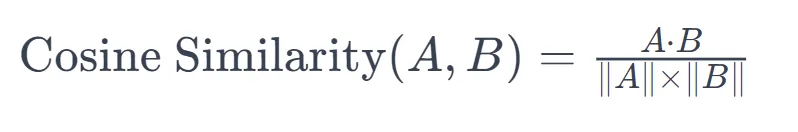


In [ ]:
import numpy as np  
import pandas as pd  
from sklearn.metrics.pairwise import cosine_similarity  

def get_recommendations(idx, pipeline, df, top_n=5):  
        """  
        Dado el índice de una raza, calcula las recomendaciones utilizando la similitud coseno  
        y devuelve la información de la raza de consulta y de las razas recomendadas.  
        
        Parámetros:  
        - idx: Índice en el DataFrame (df) de la raza consultada.  
        - pipeline: Pipeline para transformar los datos.  
        - df: DataFrame original con la información de las razas.  
        - top_n: Número de recomendaciones a retornar (por defecto 5).  
        
        Retorna:  
        - query_item: DataFrame con la información de la raza consultada.  
        - recommendations: DataFrame con la información de las razas recomendadas, ordenado de mayor a menor similitud.  
        """  
        # Transformamos todos los datos usando el pipeline  
        X_transformed = pipeline.transform(df)  
        
        # Calculamos la similitud de coseno
        sim_matrix = cosine_similarity(X_transformed)  
        sim_scores = sim_matrix[idx]  
        
        # Ordenamos índices por similitud descendente (excluyendo el mismo índice)  
        sim_idx = np.argsort(sim_scores)[::-1]  
        sim_idx = sim_idx[sim_idx != idx]  # Excluimos el propio elemento  
        top_indices = sim_idx[:top_n]  
        
        # Extraemos información del elemento consultado y de los recomendados  
        query_item = df.iloc[[idx]]  # Convertimos a DataFrame  
        recommendations = df.iloc[top_indices].copy()  
        recommendations['similarity_score'] = sim_scores[top_indices]  
        
        return query_item, recommendations  

#### **4.1. Experimentación del modelo**

Con el pipeline definido anteriormente y el sistema entrenado, se puede realizar una experimentación llamando a la función que genera el pipeline proporcionando un número de raza para que el sistema calcule sus recomendaciones basadas en similitud.

Por ejemplo, la raza Alaskan Malamute:

In [48]:
# Ejemplo de uso:  
example_idx = 4

Información de la raza consultada:

In [49]:
df_clean.iloc[[example_idx]]

,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58.0,58.42,63.5,34.019428,38.555351,10.0,14.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.8,Friendly


Recomendaciones:

In [ ]:
query, recs = get_recommendations(example_idx, pipeline, df_clean, top_n=5)  
recs

,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category,similarity_score
48,Borzoi,"Borzoi are large, elegant sighthounds. A matur...","Affectionate, Loyal, Regally Dignified",103.0,66.04,71.12,27.215542,47.627199,9.0,14.0,...,Weekly Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.6,Alert/Responsive,0.700490
136,Irish Setter,The Irish Setter has been described by its par...,"Active, Outgoing, Sweet-Natured",77.0,63.50,68.58,27.215542,31.751466,12.0,15.0,...,2-3 Times a Week Brushing,0.6,Seasonal,1.0,Needs Lots of Activity,0.6,Agreeable,1.0,Outgoing,0.661002
260,Transylvanian Hound,The Transylvanian Hound is an ancient Hungaria...,"Courageous, Good-Natured, Determined",96.0,55.88,66.04,24.947580,24.947580,10.0,14.0,...,Weekly Brushing,0.6,Seasonal,1.0,Needs Lots of Activity,0.2,May be Stubborn,NaN,Friendly,0.655860
73,Chesapeake Bay Retriever,"Chessies are strong, powerfully built gundogs ...","Affectionate, Bright, Sensitive",45.0,53.34,66.04,24.947580,36.287390,10.0,13.0,...,2-3 Times a Week Brushing,0.8,Regularly,0.8,Energetic,0.6,Agreeable,0.4,Reserved with Strangers,0.630227
93,Dogo Argentino,The ideal Dogo Argentino is a study in harmony...,"Friendly, Cheerful, Humble",96.0,60.96,67.31,39.916129,45.359237,9.0,15.0,...,Occasional Bath/Brush,0.2,Infrequent,1.0,Needs Lots of Activity,0.6,Agreeable,NaN,Friendly,0.612175


### **5. Aproximación usando embeddings mediante SpaCy**

Se decidió realizar otra experimentación pero utilizando embeddings que pudieran comparar razas a patir de sus descripciones textuales y temperamentos. Se utilizó la librería Spacy para generar representaciones vectoriales de los textos. 

El proceso consistió en:
- **Preprocesamiento:** Se combinan las columnas description y temperament en un solo texto por raza.
- **Vectorización:** Se aplican embeddings de forma automática con spacy
- **Cálculo de similitud:** Se mide la cercanía entre los vectores de cada raza.
- **Generación de recomendaciones:** Se listan las razas más similares semánticamente.


> En esta experimentación se usan unicamente las columnas de descripción y temperamento, en lugar de todo el conjunto de datos completo.

In [46]:
import spacy  
import pandas as pd  

try:  
    nlp = spacy.load('en_core_web_md')  
except Exception as e:  
    from spacy.cli import download  
    download('en_core_web_md')  
    nlp = spacy.load('en_core_web_md')  

# Concatenamos las columnas de descripciones y temperamentos en un solo campo de texto para cada raza.  
df['text_combined'] = df['description'].fillna('') + ' ' + df['temperament'].fillna('')  

# Aplicamos spaCy a los textos  
df['doc'] = df['text_combined'].apply(nlp)  

# Calculamos similitud entre una raza y todas las demás  
base_doc = df.loc[4, 'doc']  
df['similarity'] = df['doc'].apply(lambda x: base_doc.similarity(x))  

# Ordenamos según la similitud y mostrar las 5 razas más similares 
similar_races = df[['breed', 'similarity']].sort_values(by='similarity', ascending=False).head(10)
similar_races

,breed,similarity
4,Alaskan Malamute,1.000000
110,French Bulldog,0.992072
61,Bulldog,0.991737
43,Boerboel,0.991518
181,Old English Sheepdog,0.991458
185,Pekingese,0.991089
134,Icelandic Sheepdog,0.990919
72,Cesky Terrier,0.990761
267,West Highland White Terrier,0.990755
199,Portuguese Podengo,0.990615
